In [36]:
# import modules

import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Embedding, add

In [ ]:
# setting up directories

BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [ ]:
# Launching the model
model = VGG16()
# modifying the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output) #removing FCN layers of the architecture
# summarizing the model
model.summary()

In [ ]:
features = {}

In [ ]:
# image feature extraction
directory = os.path.join(BASE_DIR, 'Images') 
for img_name in tqdm(os.listdir(directory)):
    # loading a image
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose = 0)
    img_id = img_name.split('.')[0]
    features[img_id] = feature

In [ ]:
# Storing extracted features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# loading data from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
#loading captions file

with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_file = f.read()

In [ ]:
#image captions mapping
captions_mapping = {}

for L in tqdm(captions_file.split('\n')):
    #splitting the image name and captions.
    idcap = L.split(',')
    if(len(L) < 2):
        continue
    image_id, caption = idcap[0], idcap[1]
    #removing image id 
    image_id = image_id.split('.')[0]
    
    caption = ''.join(caption)
    
    if image_id not in captions_mapping:
        captions_mapping[image_id] = []
    captions_mapping[image_id].append(caption)

In [ ]:
print(len(captions_mapping), len(features))

In [ ]:
# Preprocessing the captions data
def clean(captions_mapping):
    for key, captions in captions_mapping.items():
        for i in range(len(captions)):
            # Taking one caption at a time
            caption = captions[i]
            # Convert to lower case
            caption = caption.lower()
            # Delete digits, special characters etc...
            caption = caption.replace('[^A-Za-z]', '')
            # Delete additional spaces
            caption = caption.replace('\s+', ' ')
            # Adding start and end tags to the caption
#             caption = '<start> ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' <end>'
            caption = ' '.join([word for word in caption.split() if len(word) > 1])
            captions[i] = caption

In [ ]:
# Before preprocessing the captions
captions_mapping['1000268201_693b08cb0e']

In [ ]:
# After preprocessing the captions
clean(captions_mapping)
captions_mapping['1000268201_693b08cb0e']

In [ ]:
# Gathering all the captions into a single list
all_captions = []
for key in captions_mapping:
    for caption in captions_mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

In [ ]:
# Counts total no.of words in a array of strings excluding some special characters like punctuation marks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

In [ ]:
# Get the maximum length of the caption
max_length = max([len(caption.split()) for caption in all_captions])
max_length

In [ ]:
# Splitting the tarin and test data
img_ids = list(captions_mapping.keys())
split = int(len(img_ids)*0.9)
train_data = img_ids[:split]
test_data = img_ids[split:]

In [ ]:
print(len(train_data), len(test_data))
print(train_data[189])

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train_data) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train_data, captions_mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [33]:
from tensorflow.keras.models import Model, load_model

In [34]:
model = load_model(WORKING_DIR+'/best_model.h5')

In [35]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [37]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [39]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_data):
    # get actual caption
    captions = captions_mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
korean man sells soda
man is sitting at an outside bar near many soda and beer cans
man wearing glasses with aluminum cans lined up in front of him
an elderly man is smiling while sitting in front of row of soda cans
vendor selling drinks in stall
--------------------Predicted--------------------
startseq shop sells soda while man in white shirt is selling beer in the air with beer cans in the background around him around the wall with beer cans around


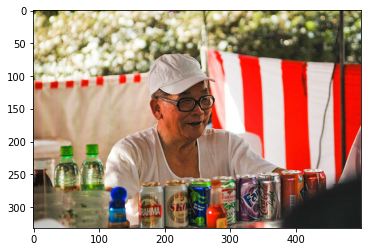

In [41]:
generate_caption('1234817607_924893f6e1.jpg')

---------------------Actual---------------------
man drilling hole in the ice
man is drilling through the frozen ice of pond
person in the snow drilling hole in the ice
person standing on frozen lake
two men are ice fishing
--------------------Predicted--------------------
startseq ice ice ice ice with many people and people watch the photographer on the ice with his head and boots walks around the side of the beach below him


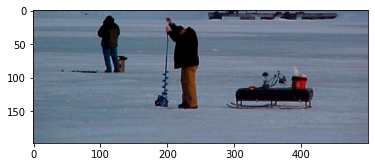

In [47]:
generate_caption('102351840_323e3de834.jpg')